In [1]:
import pandas as pd
import random


### Prime Number Functions

**`is_prime(n)`**  
- Checks if a number `n` is prime.
- Returns `True` if `n > 1` and divisible only by 1 and itself, else `False`.

**`next_prime(n)`**  
- Finds the next prime number ≥ `n`.
- Uses `is_prime` to incrementally check numbers until a prime is found.


In [2]:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

def next_prime(n):
    while not is_prime(n):
        n += 1
    return n


### Loading and Merging Datasets

1. **Load Datasets**  
   - `ratings`: Contains user ratings for movies (`rating.csv`).  
   - `movies`: Contains movie information (`movie.csv`).

2. **Merge Datasets**  
   - Combine `ratings` and `movies` on the `movieId` column using an inner join.  
   - Result: A unified DataFrame `df` with movie ratings and details.

3. **Preview the Data**  
   - Display the first few rows of the merged DataFrame using `df.head()`.


In [ ]:
ratings = pd.read_csv('rating.csv')  
movies = pd.read_csv('movie.csv')    

df = pd.merge(ratings, movies, on='movieId', how='inner')


In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.info()


In [ ]:
df.nunique()

### MinHash Implementation from Scratch

**`minhash_scratch(user_movie_dict, perm)`**

1. **Purpose**  
   - Generate MinHash signatures for each user based on the movies they have rated.  

2. **Parameters**  
   - `user_movie_dict`: Dictionary where keys are users and values are lists of movie IDs.  
   - `perm`: Number of hash functions (permutations) to use for the MinHash computation.

3. **Logic**  
   - **Generate Unique Movie Set:** Extract all unique movie IDs across all users.  
   - **Hash Functions:**  
     - Generate `perm` random coefficients `a` and `b` for hash functions.  
     - Use a prime number `p` greater than the total number of movies to ensure good hashing.  
   - **Initialization:** Create a dictionary to store MinHash signatures (`user_sign`), initialized with infinity (`float('inf')`) for each permutation.  
   - **Hash Computation:**  
     - For each user and their rated movies:  
       - Compute the hash value for each movie using \( \text{hash} = (a \cdot \text{movieId} + b) \% p \).  
       - Update the user's MinHash signature with the smallest hash value for each permutation.

4. **Return**  
   - `user_sign`: Dictionary containing MinHash signatures for each user.



In [8]:
def minhash_scratch(user_movie_dict, perm):
    all_movies = set(movie for movies in user_movie_dict.values() for movie in movies)

    a_vals = [random.randint(1,len(all_movies)) for i in range(perm)]
    b_vals = [random.randint(0,len(all_movies)) for i in range(perm)]

    p = next_prime(len(all_movies) + 1)

    user_sign = {user : [float('inf')] * perm for user in user_movie_dict}

    for user, movies in user_movie_dict.items():
        for movie in movies:
            for i in range(perm):
                hash_value = (a_vals[i] * movie + b_vals[i]) % p ## Why we need the smallest hash values??
                if hash_value < user_sign[user][i]:
                    user_sign[user][i] = hash_value
    
    return user_sign

### Creating `user_movie_dict`

- **Group by `userId`:** Groups the DataFrame by users.
- **Extract `movieId`:** Collects all movie IDs each user has rated.
- **Convert to List:** Combines the movie IDs into lists for each user.
- **Convert to Dictionary:** Creates a dictionary where:
  - Keys: `userId` (user identifiers).
  - Values: Lists of `movieId` (movies rated by the user).

**Result:**  
A dictionary `user_movie_dict` where each user is associated with the list of movies they have rated.


In [9]:
user_movie_dict = df.groupby('userId')['movieId'].apply(list).to_dict()

In [ ]:
user_movie_dict

### Locality-Sensitive Hashing (LSH) from Scratch

**`lsh_scratch(minhash_signatures, num_bands, rows_per_band)`**

1. **Purpose**  
   - Implements the LSH algorithm to group users with similar MinHash signatures into the same buckets and identify candidate pairs for similarity checks.

2. **Parameters**  
   - `minhash_signatures`: Dictionary of users and their MinHash signatures.  
   - `num_bands`: Number of bands to divide the signatures into.  
   - `rows_per_band`: Number of rows in each band.

3. **Logic**  
   - **Assertion Check:** Ensures the total number of rows in bands matches the signature length.  
   - **Initialization:**
     - `buckets`: Stores all users grouped by their bucket hash.
     - `candidate_pairs`: Holds all user pairs identified as candidates for similarity.  
   - **Band Processing:**  
     - For each band, slice the signature into sub-sections (`start_idx:end_idx`).  
     - Hash each band to a `band_hash` and group users with the same hash into `band_buckets`.
     - Print debug information: Band number, hash, and grouped users.
   - **Update Buckets:**  
     - Add the users in `band_buckets` to the global `buckets` structure.  
   - **Identify Candidate Pairs:**  
     - For users in the same `band_buckets` group, generate all possible user pairs.

4. **Return Values**  
   - `buckets`: Dictionary containing users grouped by bucket hash.  
   - `candidate_pairs`: Set of user pairs identified as candidates for further similarity evaluation.

5. **Key Steps:**
   - **Band Hashing:**  
     Users with similar MinHash signatures fall into the same bucket, increasing the likelihood of finding similar users.
   - **Candidate Pair Generation:**  
     User pairs in the same bucket are flagged as potentially similar for detailed similarity checks.

**Debugging Output:**  
For each band, the band index, hash values, and associated users are printed for tracking progress.


In [13]:
from collections import defaultdict

def lsh_scratch(minhash_signatures, num_bands, rows_per_band):
    assert num_bands * rows_per_band == len(list(minhash_signatures.values())[0]), \
        "ERROR: num_bands * rows_per_band does not match the signature length."

    buckets = defaultdict(list)
    candidate_pairs = set()

    for band_idx in range(num_bands):
        band_buckets = defaultdict(list)

        for user, signature in minhash_signatures.items():
            start_idx = band_idx * rows_per_band
            end_idx = start_idx + rows_per_band
            band = tuple(signature[start_idx:end_idx])

            band_hash = hash(band)  # Built-in Python hash
            band_buckets[band_hash].append(user)

            print(f"Band {band_idx}, Hash {band_hash}: {band_buckets[band_hash]}")

        # Add users to general buckets
        for band_hash, users in band_buckets.items():
            buckets[band_hash].extend(users)

        # Check for candidate pairs
        for bucket_users in band_buckets.values():
            if len(bucket_users) > 1:
                for i in range(len(bucket_users)):
                    for j in range(i + 1, len(bucket_users)):
                        candidate_pairs.add((bucket_users[i], bucket_users[j]))

    return buckets, candidate_pairs


In [11]:
minhash_signatures = minhash_scratch(user_movie_dict, 32)

In [ ]:
minhash_signatures

In [ ]:
num_bands = 8
rows_per_band = 4

buckets, candidate_pairs = lsh_scratch(minhash_signatures, num_bands, rows_per_band)



In [ ]:
buckets

In [ ]:
candidate_pairs

In [ ]:
len(buckets)

In [ ]:
len(candidate_pairs)

### Finding Similar Users

**Function:** `find_similar_users(candidate_pairs, user_movie_dict)`

This function identifies and ranks similar users based on the number of movies they have in common, leveraging the candidate pairs generated by the LSH algorithm.

---

#### **1. Parameters**
- **`candidate_pairs`**: Set of user pairs identified as potentially similar.  
- **`user_movie_dict`**: Dictionary mapping users to the list of movies they have rated.

---

#### **2. Logic**
- **Step 1: Calculate Common Movies**  
  - For each user pair in `candidate_pairs`:  
    - Retrieve their respective movie lists and convert them into sets.  
    - Compute the intersection of the sets to find common movies.  
    - If the intersection is non-empty, add the pair to the `similar_users` dictionary, along with the count of common movies.  

- **Step 2: Sort Similar Users**  
  - For each user, sort their list of similar users in descending order of the number of common movies.

---

#### **3. Return Value**
- **`similar_users`**:  
  A dictionary where each user is mapped to a list of tuples.  
  - Each tuple contains:  
    1. A similar user.  
    2. The number of movies they have in common.  
  - The list is sorted by the number of common movies (highest first).

---

#### **4. Example Workflow**

**Input:**  
```python
candidate_pairs = {('User1', 'User2'), ('User1', 'User3')}
user_movie_dict = {
    'User1': [101, 102, 103],
    'User2': [101, 103, 104],
    'User3': [102, 105]
}



---

**Output:**  
```python
{
    'User1': [('User2', 2), ('User3', 1)],
    'User2': [('User1', 2)],
    'User3': [('User1', 1)]
}


In [23]:
def find_similar_users(candidate_pairs, user_movie_dict):
    similar_users = defaultdict(list)  

    for user1, user2 in candidate_pairs:
        movies_user1 = set(user_movie_dict[user1])
        movies_user2 = set(user_movie_dict[user2])
        
        common_movies = movies_user1.intersection(movies_user2)
        
        if len(common_movies) > 0:
            similar_users[user1].append((user2, len(common_movies)))
            similar_users[user2].append((user1, len(common_movies)))

    for user in similar_users:
        similar_users[user] = sorted(similar_users[user], key=lambda x: x[1], reverse=True)
    
    return similar_users


### Movie Recommendation Function

**Function:** `recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5)`

This function recommends movies to a user based on the preferences of similar users.

---

#### **1. Parameters**
- **`user`**: The target user for whom the recommendations are generated.  
- **`similar_users`**: A dictionary mapping users to their similar users and the number of common movies.  
- **`user_movie_dict`**: A dictionary mapping users to the list of movies they have rated.  
- **`rating_dict`**: A dictionary mapping users to their movie ratings as `{movieId: rating}`.  
- **`max_recommendations`**: The maximum number of movies to recommend (default is 5).

---

#### **2. Logic**
1. **Identify Movies Already Watched**  
   - Extract the list of movies the target user has already watched to avoid recommending these.

2. **Iterate Over Similar Users**  
   - For each similar user:
     - Identify the movies they have watched but the target user has not (`unseen_movies`).

3. **Aggregate Ratings for Unseen Movies**  
   - For each unseen movie:
     - If it is not already in the recommendation list, add it with the similar user's rating.
     - If it is already in the list, add the rating to its existing score.  
   - This ensures that movies recommended by multiple similar users receive a higher score.

4. **Sort Recommendations**  
   - Sort the unseen movies by their aggregated scores in descending order.

5. **Return Top Recommendations**  
   - Return the top `max_recommendations` movies from the sorted list.

---

#### **3. Return Value**
- A list of movie IDs representing the top recommended movies, sorted by their scores.

---

#### **4. Example Workflow**

**Input:**  
```python
user = 'User1'
similar_users = {
    'User1': [('User2', 5), ('User3', 3)]
}
user_movie_dict = {
    'User1': [101, 102],
    'User2': [102, 103],
    'User3': [103, 104]
}
rating_dict = {
    'User2': {102: 4, 103: 5},
    'User3': {103: 3, 104: 4}
}


---

**Output:**  
```python
[103, 104]


In [20]:
def recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5):
    user_movies = set(user_movie_dict[user]) 
    recommendations = {}

    if user not in similar_users:
        return []  
    
    for similar_user, _ in similar_users[user]:
        similar_user_movies = set(user_movie_dict[similar_user])
        
        unseen_movies = similar_user_movies - user_movies
        
        for movie in unseen_movies:
            if movie not in recommendations:
                recommendations[movie] = rating_dict[similar_user].get(movie, 0)  
            else:
                recommendations[movie] += rating_dict[similar_user].get(movie, 0) 
    
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    return [movie for movie, _ in sorted_recommendations[:max_recommendations]]


### Creating `rating_dict`

**Purpose:**  
Creates a dictionary mapping each `userId` to their rated `movieId` and corresponding `rating`.

**Steps:**  
1. **Group by `userId`:** Groups movies and ratings for each user.  
2. **`zip` and `dict`:** Combines `movieId` and `rating` into a dictionary for each user.  
3. **Convert to `dict`:** Creates a nested dictionary.

**Result:**  
A dictionary in the format:
```python
{
    'User1': {101: 4.0, 102: 5.0},
    'User2': {103: 3.5, 104: 4.0},
    ...
}


In [21]:
rating_dict = (
    df.groupby('userId')
    .apply(lambda x: dict(zip(x['movieId'], x['rating'])))
    .to_dict()
)


In [24]:
similar_users = find_similar_users(candidate_pairs, user_movie_dict)

In [ ]:
similar_users

In [ ]:
user_id = 2 
recommended_movies = recommend_movies(user_id, similar_users, user_movie_dict, rating_dict)

print(f"Recommended Movies for User {user_id}: {recommended_movies}")

In [ ]:
user_id = 1 
recommended_movies = recommend_movies(user_id, similar_users, user_movie_dict, rating_dict)

print(f"Recommended Movies for User {user_id}: {recommended_movies}")

### Algorithmic question

#### a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).
The possible strategy is to calculate all the possible final scores that each player can obtain based on the various sequences of possible choices.; <br>
This can be done recursively, simulating all the possible choices and outcomes that can be achieved, assuming that the other player plays optimally.

##### Recursive algorithm explanation:

---

**Input:**  
- `num`: List of numbers.

**Variable inizialized during the algorithm**
- `arya_score`: Arya's score (default is 0).  
- `mario_score`: Mario's score (default is 0).
- `arya_moves`: List of best moves for Arya.
- `mario_moves`: List of best moves for Mario.
- `turn`: Boolean indicating whose turn it is (True for Arya, False for Mario).  

**Output:**  
- Final scores and moves of both players: `(arya_score, mario_score, arya_moves, mario_moves)`.  

--- 

**Algorithm:**

1. **Base Case:**
   - If `num` is empty, return best scores and moves for both players `(arya_score, bran_score, arya_moves, bran_moves)`.

2. **Arya's turn:**
   1. Simulate both choices, create 2 tuples with possible score of both players if Arya choose Head or Tail:
      - `choose_head`: Recursively call the function with `num[1:]` (excluding the head), adding `num[0]` to `arya_score` and appending head number `num[0]` to her moves.
      - `choose_tail`: Recursively call the function with `num[:-1]` (excluding the tail), adding `num[-1]` to `arya_score` and appending tail number `num[-1]` to her moves.
   2. Compare the results:
      - If head choice is better than tail choice, `choose_head[0] > choose_tail[0]`, return *choose_head*, which contains best scores and moves for both players if Arya choose to follow head number path.
      - Otherwise, return *choose_tail*, which contains best scores and moves for both players if Arya choose to follow tail number path.

3. **Mario's turn:**
   1. Simulate both choices, create 2 tuples with possible score of both players if Mario choose Head or Tail:
      - `choose_head`: Recursively call the function with `num[1:]` (excluding the head), adding `num[0]` to `mario_score` and appending head number `num[0]` to his moves.
      - `choose_tail`: Recursively call the function with `num[:-1]` (excluding the tail), adding `num[-1]` to `mario_score` and appending tail number `num[-1]` to his moves.
   2. Compare the results:
      - If head choice is better than tail choice, `choose_head[1] > choose_tail[1]`, return *choose_head*, which contains best scores and moves for both players if Mario choose to follow head number path.
      - Otherwise, return choose_tail, which contains best scores and moves for both players if Mario choose to follow tail number path.

##### Recursive algorithm pseudocode:

**Algorithm: *recursive_strategy(num)***

**INITIALIZE** arya_score <- 0 <br>
**INITIALIZE** mario_score <- 0 <br>
**INITIALIZE** arya_moves <- [] <br>
**INITIALIZE** mario_moves <- [] <br>

***Base case:***
1. **IF** *len(num) == 0* 
    - **return** *(arya_score, mario_score, arya_moves, mario_moves)*

***Arya's turn:*** <br>

2. **IF** *turn == True*:  
    - **choose_head** <- ***recursive_strategy**(num[1:], arya_score + num[0], mario_score, arya_moves + [num[0]], mario_moves, !turn)*
    - **choose_tail** <- ***recursive_strategy**(num[:-1], arya_score + num[-1], mario_score, arya_moves + [num[-1]], mario_move, !turn)*

    - **if** *choose_head[0] > choose_tail[0]*:
      - **return** *choose_head*
    - **else**
      - **return** *choose_tail*

***Mario's turn***

3. **ELSE**
    - **choose_head** <- ***recursive_strategy**(num[1:], arya_score, mario_score + num[0], arya_moves, mario_moves + [ num[0] ], !turn)*
    - **choose_tail** <- ***recursive_strategy**(num[:-1], arya_score, mario_score + num[-1], arya_moves, mario_moves + [ num[-1] ], !turn)*  
  
    - **IF** *choose_head[1] > choose_tail[1]*:
      - **return** *choose_head*
    - **ELSE**
      - **return** *choose_tail* 

#### b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.

In [3]:
import random

def recursive_strategy(num, arya_score=0, mario_score=0, arya_moves=None, mario_moves=None, turn=True):
    if arya_moves is None:
        arya_moves = []
    if mario_moves is None:
        mario_moves = []

    # Base case, num empty
    if not num:
        return arya_score, mario_score, arya_moves, mario_moves

    # Arya's turn
    if turn:  
        # Simulate best possible scores and moves for head and tail
        choose_head = recursive_strategy(num[1:], 
                                         arya_score + num[0], 
                                         mario_score, 
                                         arya_moves + [num[0]], 
                                         mario_moves, 
                                         not turn)
        
        choose_tail = recursive_strategy(num[:-1], 
                                         arya_score + num[-1], 
                                         mario_score, 
                                         arya_moves + [num[-1]], 
                                         mario_moves, not turn)

        # Arya selects the move that maximizes her score
        if choose_head[0] > choose_tail[0]:
            return choose_head
        else:
            return choose_tail

    # Mario's turn
    else:  
        # Simulate best possible scores and moves for head and tail
        choose_head = recursive_strategy(num[1:], 
                                         arya_score, 
                                         mario_score + num[0], 
                                         arya_moves, 
                                         mario_moves + [num[0]], 
                                         not turn)
        
        choose_tail = recursive_strategy(num[:-1], 
                                         arya_score, 
                                         mario_score + num[-1], 
                                         arya_moves, 
                                         mario_moves + [num[-1]], 
                                         not turn)

        # Mario selects the move that maximizes his score
        if choose_head[1] > choose_tail[1]:
            return choose_head
        else:
            return choose_tail

# Example usage
# Example usage on different size lists
random.seed(123)

listSize = 7
trySize = 10

nums = [[random.randint(1, 100) for _ in range(i)] for i in range (3, trySize)]

for num in nums:
    print("List", num)
    n = len(num)
    arya_score, mario_score, arya_moves, mario_moves = recursive_strategy(num, n)
    print("Arya's best score:", arya_score)
    print("Arya best strategy is to take, in sequence", mario_moves)
    print()



List [7, 35, 12]
Arya's best score: 22
Arya best strategy is to take, in sequence [35]

List [99, 53, 35, 14]
Arya's best score: 138
Arya best strategy is to take, in sequence [53, 14]

List [5, 49, 69, 72, 43]
Arya's best score: 122
Arya best strategy is to take, in sequence [72, 49]

List [44, 7, 21, 18, 44, 72]
Arya's best score: 143
Arya best strategy is to take, in sequence [44, 18, 7]

List [43, 90, 32, 21, 1, 56, 100]
Arya's best score: 183
Arya best strategy is to take, in sequence [56, 21, 90]

List [12, 77, 49, 9, 1, 41, 94, 58]
Arya's best score: 193
Arya best strategy is to take, in sequence [94, 1, 49, 12]

List [14, 6, 12, 86, 19, 17, 3, 38, 56]
Arya's best score: 113
Arya best strategy is to take, in sequence [38, 17, 6, 86]



#### c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.

**Computational Cost Analysis**

This algorithm exhaustively explores all possible combinations of moves for Arya and Mario. Each recursive branch represents a decision (choosing head or tail) and explores all subsequent moves optimally. Without memoization, the same subproblems (overlapping intervals) are recalculated multiple times, leading to exponential time growth.

1. ***Function Behavior***: <br>
At each step, the function simulates both possible moves (taking the number at the head or the tail of the list). <br>
The size of the list `num` decreases by 1 at each recursive call, but for every call, two branches of the recursion are created and explored.

2. ***Recursive Tree Depth***: <br>
The recursion depth is equal to the number of elements in the list num, which is `n`, this takes ***O(n)*** time.

3. ***Number of Recursive Calls***: <br>
For a list of length `n` the recursion tree has **2<sup>n</sup> - 1** nodes because every choice branches into two further calls.

4. ***Overall Time Complexity***: <br>
Given that decision over the n numbers of the list create two recursive call, in `point 2.1` for Arya and in `point 3.1` for Mario, and that they also create other 2 recursive call each, the total time complexity of the algortihm is **exponential**, in particular, it is **O(n 2<sup>n</sup>)**




#### d) *If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.*

The following algorithm solves the problem using dynamic programming. The algorithm builds a table to store the results of subarray calculations, avoiding redundant computations, as we did in recursive algorithm.

---

**Input:**  
- `num`: List of numbers.

**Output:**  
- Final scores and moves of both players:  
  - `Arya_score`: Arya's score.  
  - `mario_score`: mario's score.  
  - `Arya_moves`: List of best moves for Arya.
  - `mario_moves`: List of best moves for Mario.

---

**Algorithm:**

1. **Initialization:**  
   - Create a 2D table `score_table` to store maximum score difference for the current player subarrays `num[i:j+1]`.
   - Another 2D table moves is created to store sequence of moves both players takes when playing optimally on subarrays `num[i:j+1]`.
   - `total_sum` accumulates the sum of all elements in the array.

2. **Fill up the table:**
    
   - If there is only one element in the subarray `i == j`, Arya takes it.  
   - Otherwise, Arya has two choices and takes the one that maximized her score difference:  
     - **Arya's Choices:**  
       1. Pick the first element `num[i]` and let Mario play optimally in the remaining subarray `num[i+1:j+1]`.
       2. Pick the last element `num[j]` and let Mario play optimally in the remaining subarray `num[i:j]`.  

3. **Moves tracking:**
    - If Arya picks the first element, the move is added to the sequence, followed by the optimal sequence for `num[i+1:j+1]`
    - If Arya picks the last element, the move is added to the sequence, followed by the optimal sequence for `num[i:j]`

4. **Result:**
    - The final answer for the entire array is stored in `score_table[0][n-1]`. Return the scores and moves from this cell.


##### Optimized Algorithm Pseudocode

**Algorithm: optimized_game(num, n):**

1. Initialization
    - total_sum <- 0 <br>
    - **CREATE** 2D array *score_table[ n ][ n ]* initialized to *0* <br>
    - **CREATE** 2D array *moves[ n ][ n ]* initialized to *empty lists* <br>

2. Iteratively fill up the score_table

    - **FOR** *i* **FROM** *n-1* **TO** *0*: 
        - **total_sum** += *num[ i ]* <br>
        
        - **FOR** *j* **FROM** *i* **TO** *n-1*:
            - **IF** *i == j*:
                - **score_table[ i ][ j ]** <- *num[ i ]*
                - **moves[ i ][ j ]** <- *[ num[ i ] ]*
            - **ELSE**:
                - **pick_start** <- *num[ i ] - score_table[ i+1 ][ j ]*
                - **pick_end** <- *num[j] - score_table[ i ][ j-1 ]*

                - **IF** *pick_start > pick_end*:
                    - score_table[ i ][ j ] <- *pick_start*
                    - moves[ i ][ j ] <- *[ num[ i ] ] + moves[ i+1 ][ j ]*
                - **ELSE**:
                    - **score_table[ i ][ j ]** <- *pick_end*
                    - **moves[ i ][ j ]** <- *[ num[ j ] ] + moves[ i ][ j-1 ]*

- **arya_score** <- *(total_sum + score_table[ 0 ][ n-1 ]) // 2*
- **RETURN** *arya_score*, *mario_score*, *moves[ 0 ][ n-1 ]*, *moves[0][n - 1][1::2]*

#### e) *Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.*

In [4]:
import random

def optimized_game(num, n):
    # Total sum of numbers in the list
    total_sum = 0
    # Table for score storing
    score_table = [[0] * n for _ in range(n)] 
    # Table for moves tracking
    moves = [[[] for _ in range(n)] for _ in range(n)]  # Move tracking
    
    # Iterate from the end to the start
    for i in range(n - 1, -1, -1):
        total_sum += num[i]
        for j in range(i, n):
            if i == j:
                score_table[i][j] = num[i]
                moves[i][j] = [num[i]]  # Single element, pick it
            else:
                # Two options: pick the head number (start) or the tail number (end)
                pick_start = num[i] - score_table[i + 1][j]
                pick_end = num[j] - score_table[i][j - 1]
                
                if pick_start > pick_end:
                    score_table[i][j] = pick_start
                    # Pick start and add the rest
                    moves[i][j] = [num[i]] + moves[i + 1][j]
                else:
                    score_table[i][j] = pick_end
                    # Pick end and add the rest
                    moves[i][j] = [num[j]] + moves[i][j - 1]  
                    
    # Calculate Arya's maximum score
    arya_score = (total_sum + score_table[0][n - 1]) // 2
    # Create return variables [arya_score, mario_score, arya_moves, mario_moves]
    return arya_score, total_sum - arya_score, moves[0][n - 1][::2], moves[0][n - 1][1::2]


# Example usage on different size lists
random.seed(123)

listSize = 7
trySize = 10

nums = [[random.randint(1, 100) for _ in range(i)] for i in range (3, trySize)]

for num in nums:
    print("List", num)
    n = len(num)
    arya_score, mario_score, arya_moves, mario_moves = optimized_game(num, n)
    print("Arya's best score:", arya_score)
    print("Arya best strategy is to take, in sequence", mario_moves)
    print()

List [7, 35, 12]
Arya's best score: 19
Arya best strategy is to take, in sequence [35]

List [99, 53, 35, 14]
Arya's best score: 134
Arya best strategy is to take, in sequence [53, 14]

List [5, 49, 69, 72, 43]
Arya's best score: 117
Arya best strategy is to take, in sequence [72, 49]

List [44, 7, 21, 18, 44, 72]
Arya's best score: 137
Arya best strategy is to take, in sequence [44, 18, 7]

List [43, 90, 32, 21, 1, 56, 100]
Arya's best score: 176
Arya best strategy is to take, in sequence [56, 21, 90]

List [12, 77, 49, 9, 1, 41, 94, 58]
Arya's best score: 185
Arya best strategy is to take, in sequence [94, 1, 49, 12]

List [14, 6, 12, 86, 19, 17, 3, 38, 56]
Arya's best score: 104
Arya best strategy is to take, in sequence [38, 17, 6, 86]



**Computational Cost Analysis**
- Initialization of tables take, each, ***O(n<sup>2</sup>)***, where n is the size of the list of number.
- Filling the table involves two nested loops:
    -   Outer loop: ***O(n)***
    -   Inner loop: ***O(n)***
    -   For each iteration in the inner loop, constant time ***O(1)*** work is done (calculating scores and updating moves).
    -   Overall time complexity of filling up step is ***O(n<sup>2</sup>)***
- Calculating Arya's score is done in costant time ***O(1)***.

Overall time complexity is ***O(n<sup>2</sup>)***, **polynomial** time.

#### f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.

In [5]:
def LLM_game(num):
    n = len(num)
    # Initialize DP table to store scores and moves of both players [arya_score, mario_score, arya_moves, mario_moves]
    dp = [[[0, 0, [], []] for _ in range(n)] for _ in range(n)]

    # Fill the DP table

    # Subarryas of length 1
    for i in range(n):
        dp[i][i] = [num[i], 0, [num[i]], []]

    # Subarray of length in range (2, len(num))
    for length in range(2, n + 1):
        for i in range(n - length + 1):
            j = i + length - 1
            # Arya's choices: pick head or tail
            head_arya_score = num[i] + dp[i + 1][j][1]
            tail_arya_score = num[j] + dp[i][j - 1][1]

            if head_arya_score > tail_arya_score:
                dp[i][j][0] = head_arya_score  # Arya's score
                dp[i][j][1] = dp[i + 1][j][0]  # Mario's score
                dp[i][j][2] = [num[i]] + dp[i + 1][j][3]  # Arya's moves
                dp[i][j][3] = dp[i + 1][j][2]  # Mario's moves
            else:
                dp[i][j][0] = tail_arya_score  # Arya's score
                dp[i][j][1] = dp[i][j - 1][0]  # Mario's score
                dp[i][j][2] = [num[j]] + dp[i][j - 1][3]  # Arya's moves
                dp[i][j][3] = dp[i][j - 1][2]  # Mario's moves

    # Final scores and moves
    final_scores_and_moves = dp[0][n - 1]

    return final_scores_and_moves

# Example usage on different size lists
random.seed(123)

listSize = 7
trySize = 10

nums = [[random.randint(1, 100) for _ in range(i)] for i in range (3, trySize)]

for num in nums:
    print("List", num)
    n = len(num)
    arya_score, mario_score, arya_moves, mario_moves = LLM_game(num)
    print("Arya's best score:", arya_score)
    print("Arya best strategy is to take, in sequence", arya_moves)
    print()


List [7, 35, 12]
Arya's best score: 19
Arya best strategy is to take, in sequence [12, 7]

List [99, 53, 35, 14]
Arya's best score: 134
Arya best strategy is to take, in sequence [99, 35]

List [5, 49, 69, 72, 43]
Arya's best score: 117
Arya best strategy is to take, in sequence [43, 69, 5]

List [44, 7, 21, 18, 44, 72]
Arya's best score: 137
Arya best strategy is to take, in sequence [72, 44, 21]

List [43, 90, 32, 21, 1, 56, 100]
Arya's best score: 176
Arya best strategy is to take, in sequence [100, 1, 32, 43]

List [12, 77, 49, 9, 1, 41, 94, 58]
Arya's best score: 185
Arya best strategy is to take, in sequence [58, 41, 9, 77]

List [14, 6, 12, 86, 19, 17, 3, 38, 56]
Arya's best score: 104
Arya best strategy is to take, in sequence [56, 3, 14, 19, 12]



**Computational time analysis**: The optimized_game function efficiently computes Arya's and Mario's scores and their respective moves using a dynamic programming approach.

The algorithm is composed of:
- Initialization of dp table, that takes ***O(n<sup>2</sup>)*** to fill the table with zeros, where n is the size of the list of numbers. 
- A for loop that iterates ***O(n)*** times to fill the diagonal of the table to initialize single subarrays tuples.
- Two for loop that iterates almost *n* times each, so this nested loops runs in ***O(n<sup>2</sup>)*** time complexity.
- Final variable, *final_scores_and_moves*, is created in O(n) time due to iteration over all columns of the table.


So, the overall time complexity is ***O(n<sup>2</sup>)***, polynomial complexity.

**Correctness**: The proposed approach uses dynamic programming to simulate the optimal strategy for Arya. Each player's optimal choices are taken into account, and the base case and recurrence relation correctly model the dynamics of the game. The solution ensures that Arya plays optimally, assuming that both players make the best possible moves at every step.

**Validation**: To validate the results of these 3 algorithms, let's graph the success percentage on the same sets of lists of numbers. Since the 3 lines are overlapping, this means that they maximize the score in the same way.

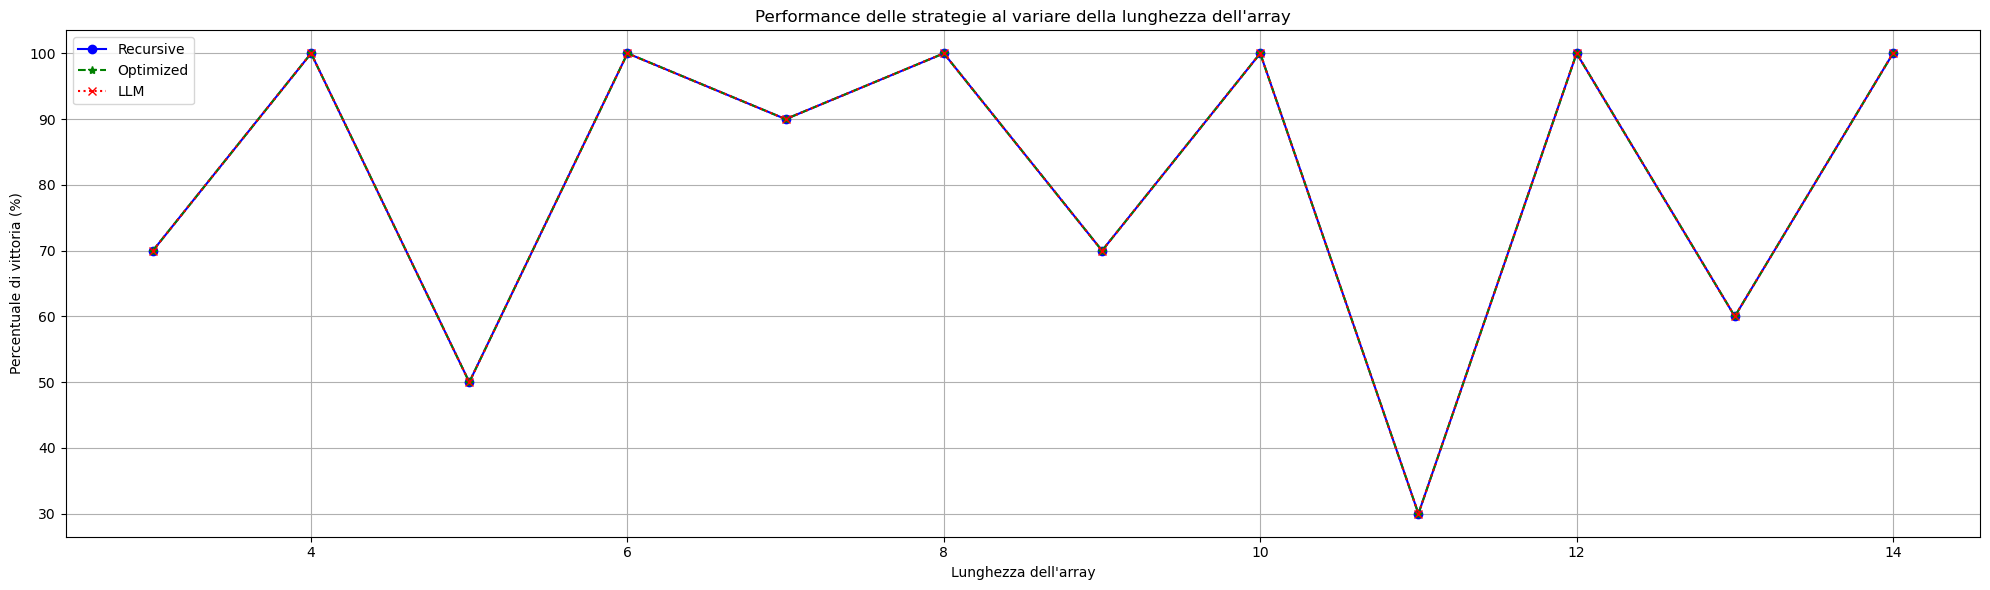

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to test the strategies
def test_strategies(maxListSize, iterations=100):
    results = {
        "recursive_strategy": [],
        "optimized_strategy": [],
        "LLM_strategy": []
    }

    # Test different size list of numbers
    for n in range(3, maxListSize):
        # Variables to track each strategie number of Arya's win over Mario
        rec_wins = 0
        optim_wins = 0
        llm_wins = 0

        # Create multiple lists of different sizes to be tested
        nums = [[random.randint(1, 100) for _ in range(n)] for i in range(iterations)]

        for num in nums:
            # Recursive Strategy
            arya_score, mario_score, arya_moves, mario_moves = recursive_strategy(num.copy())
            if arya_score > mario_score: 
                rec_wins += 1

            # Optimized Strategy
            arya_score, mario_score, arya_moves, mario_moves = optimized_game(num.copy(), len(num))
            if arya_score > mario_score: 
                optim_wins += 1

            # LLM Strategy
            arya_score, mario_score, arya_moves, mario_moves = LLM_game(num.copy())
            if arya_score > mario_score: 
                llm_wins += 1
                

        # Calculate the win percentages
        results["recursive_strategy"].append(rec_wins / iterations * 100)
        results["optimized_strategy"].append(optim_wins / iterations * 100)
        results["LLM_strategy"].append(llm_wins / iterations * 100)

    return results

# Lists max size
maxListSize = 15
# Number of tests for each size
iterations = 10  

# Test the strategies
results = test_strategies(maxListSize, iterations)

# Plot the results
plt.figure(figsize=(20, 6))

plt.plot(nums, results["recursive_strategy"], label="Recursive", marker="o", color="blue", linestyle="-")
plt.plot(nums, results["optimized_strategy"], label="Optimized", marker="*", color="green", linestyle="--")
plt.plot(nums, results["LLM_strategy"], label="LLM", marker="x", color="red", linestyle=":")

plt.title("Performance of strategies based on array size")
plt.xlabel("Array size")
plt.ylabel("Win percentage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()  # To avoid label cutting
plt.show()
